# A quick Echopype exercise

In this exercise we will do 4 things:
- convert a `.raw` file collected by an EK80 echosounder
- compute volume backscattering strength (Sv) from the parsed raw data
- regrid the Sv data to mean volume backscattering strength (MVBS)
- visualize using interactive plot

For more detials, see the [Getting started with Echopype notebook](https://echopype-examples.readthedocs.io/en/latest/getting_started.html) in the [`echopype-examples` repository](https://github.com/OSOceanAcoustics/echopype-examples).

In [1]:
import echopype as ep  # we recommend using "ep"
import xarray as xr
import hvplot.xarray  # for interactive plots

import matplotlib.pyplot as plt

### Convert a `.raw` file

In [2]:
raw_path = "s3://noaa-wcsd-pds/data/raw/Bell_M._Shimada/SH2306/EK80/Hake-D20230811-T165727.raw"
ed = ep.open_raw(
    raw_path,
    sonar_model="EK80",
    storage_options={"anon": True},  # open bucket, otherwise need credential
)

### Check what's in the raw file

In [3]:
ed

<EchoData: standardized raw data from Internal Memory>
Top-level: contains metadata about the SONAR-netCDF4 file format.
├── Environment: contains information relevant to acoustic propagation through water.
├── Platform: contains information about the platform on which the sonar is installed.
│   └── NMEA: contains information specific to the NMEA protocol.
├── Provenance: contains metadata about how the SONAR-netCDF4 version of the data were obtained.
├── Sonar: contains sonar system metadata and sonar beam groups.
│   └── Beam_group1: contains backscatter power (uncalibrated) and other beam or channel-specific data, including split-beam angle data when they exist.
└── Vendor_specific: contains vendor-specific information about the sonar and the data.

### Compute Sv

In [4]:
# Use the correct waveform_mode and encode_mode combination
ds_Sv = ep.calibrate.compute_Sv(ed, waveform_mode="CW", encode_mode="power")

Check how the Sv data look like:

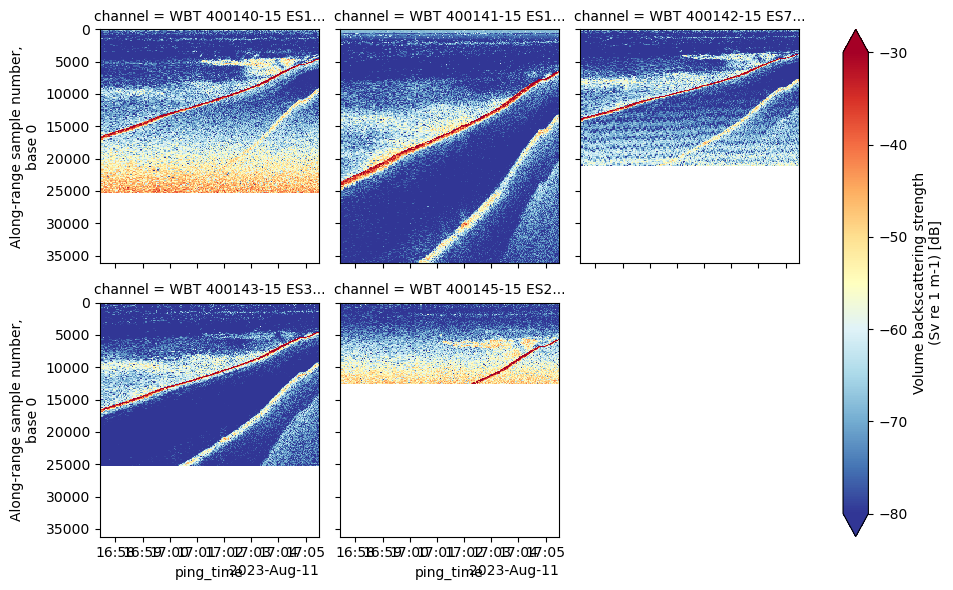

In [5]:
ds_Sv["Sv"].plot(
    x="ping_time", 
    row="channel", col_wrap=3,
    vmin=-80, vmax=-30,
    cmap="RdYlBu_r", yincrease=False
)

### Regrid to MVBS

In [6]:
# Compute MVBS
ds_MVBS = ep.commongrid.compute_MVBS(
    ds_Sv,
    range_var="echo_range",
    range_bin="1m",
    ping_time_bin="5s",
    range_var_max="500m",  # max range to bin
)

See how MVBS data are now all aligned with one another (hence the name `commingrid`):

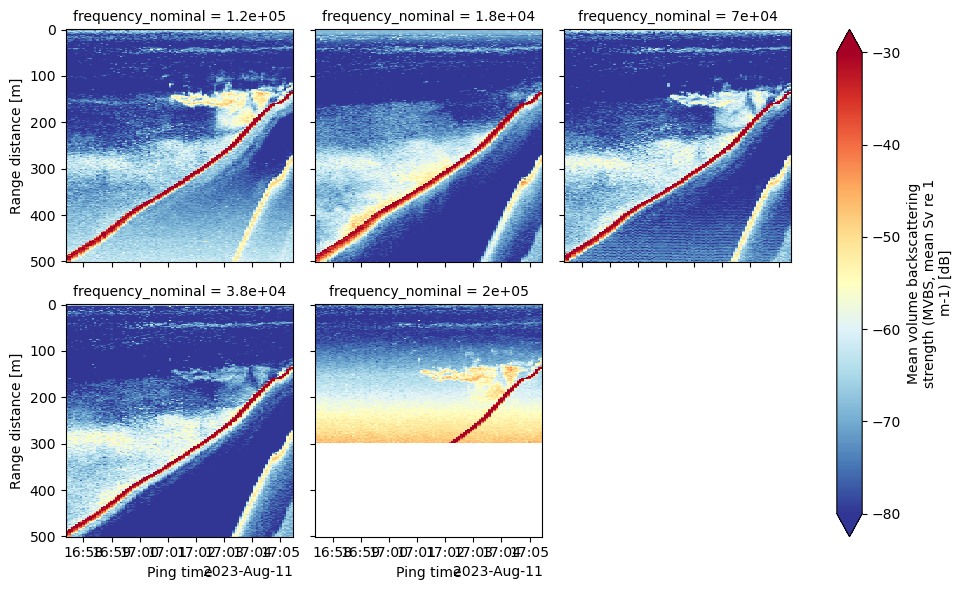

In [7]:
ds_MVBS = ds_MVBS.swap_dims({"channel": "frequency_nominal"})
ds_MVBS["Sv"].plot(
    x="ping_time",
    row="frequency_nominal", col_wrap=3,
    cmap='RdYlBu_r', yincrease=False,
    vmin=-80, vmax=-30
)

### Try interactive plotting

In [8]:
ds_MVBS["Sv"].hvplot.quadmesh(
    x="ping_time", clim=(-80, -30), figsize=(6, 6), cmap="RdYlBu_r", rasterize=True,
    groupby="frequency_nominal"
).opts(invert_yaxis=True, height=400)

BokehModel(combine_events=True, render_bundle={'docs_json': {'557dff2c-24cf-4311-aa6e-3d5725821bb4': {'version…

### Save the MVBS dataset for future use

In [10]:
ds_MVBS.to_zarr("./resources/Hake-D20230811-T165727_MVBS.zarr", mode="w")